# Do presynaptic cells co-occur in rosettes more than chance
no KC specificity unless otherwise indicated

In [1]:
%pylab inline
import seaborn as sns
import numpy as np
import pandas as pd
import cPickle as pickle
from irm import cvpipelineutil
import sklearn.neighbors
import scipy.sparse
import irm
import scipy.stats
from matplotlib.collections import LineCollection
sns.set(style="white", context="talk")


Populating the interactive namespace from numpy and matplotlib


In [2]:
neurons_data = pickle.load(open("../data/mushroombody.neurondf.pickle", 'r'))
synapse_data = pickle.load(open("../data/mushroombody.synapsesdf.pickle", 'r'))
basicmat_data = pickle.load(open("../data/mushroombody.cleandata.pickle", 'r'))
tbar_df = synapse_data['tbar_df']
connections_df = synapse_data['connections_df']
neurons_df = neurons_data['neurondf']
neuronsdf = neurons_df.set_index('body ID')


neuronsdf['name_clean'] = neuronsdf.name.apply(lambda x: str(x))



In [3]:
all_mbon_rosettes = pickle.load(open("../data/mushroombody.all-MBON.rosette.df.pickle", 'r'))
rosette_df = all_mbon_rosettes['rosette_df']


In [4]:
pre_ids_unique = np.intersect1d(np.unique(rosette_df['body ID_pre']), neurons_df['body ID'])
pre_ids_to_pos = {k:v for v, k in enumerate(pre_ids_unique)}
PREN = len(pre_ids_unique)

pre_ids_names = []

for pi in pre_ids_unique:
    a = neurons_df[neurons_df['body ID'] == pi].iloc[0]
    pre_ids_names.append(a['name'])
pre_ids_names = np.array(pre_ids_names)
rand_idx = np.argsort(pre_ids_names)# np.random.permutation(KCN)
pre_ids_names_sorted = pre_ids_names[rand_idx]

In [5]:
pre_rosette_pre_mats = {}
MAX_ROSETTE_SIZE = 25
ROSETTE_THOLD = 20
rosettes_filtered = rosette_df[ (~rosette_df.convergent_filtered)]
rosettes_filtered = rosettes_filtered[rosettes_filtered['body ID_pre'].isin(pre_ids_unique)]

res = []
for rosette_thold, rosettes_th in rosettes_filtered.groupby('rosette_thold'):
    for post_id, a in  rosettes_th.groupby('body ID_post'):

        conn_mat = np.zeros((PREN, PREN, MAX_ROSETTE_SIZE), dtype=np.uint16)

        for rosette_id, rosette in a.groupby('rosette_id'):
            pre_ids = np.unique(rosette['body ID_pre'])
            pos = [pre_ids_to_pos[pre_id] for pre_id in pre_ids]
            #if len(rosette) > 1
            rosette_size = len(rosette)
            for i in pos:
                for j in pos:
                    if i > j: # ignore same-same
                        conn_mat[i, j, rosette_size] += 1 
        #pre_rosette_pre_mats[post_name] = conn_mat


        conn_mat_count = conn_mat[:, :, 2:].sum(axis=2)

        for i, v in pd.value_counts(conn_mat_count.flatten()).iteritems():
            res.append({'body ID_post' : post_id, 'rosette_num' : i, 
                        'conn_pairs' : v, 'rosette_thold' : rosette_thold})    



counts_by_mbon = pd.DataFrame(res)
counts_by_mbon = counts_by_mbon.join(neuronsdf[['name_clean']], on='body ID_post')

In [6]:
plot_thold = 20 

true_pt = counts_by_mbon.groupby('rosette_thold').apply(lambda x : x.pivot(index='body ID_post', 
                               columns='rosette_num', values='conn_pairs')).fillna(0)
true_pt = true_pt.xs(plot_thold, level='rosette_thold').sort_values(0, ascending=True)

In [7]:
true_pt

rosette_num           0        1      2      3     4    5    6    7
body ID_post                                                       
10563         1395209.0  10449.0  847.0   82.0   5.0  3.0  0.0  1.0
54977         1395646.0  10059.0  816.0   69.0   5.0  1.0  0.0  0.0
616459        1398391.0   7277.0  808.0  101.0  15.0  3.0  1.0  0.0
3338684       1401097.0   5242.0  238.0   17.0   2.0  0.0  0.0  0.0
3878341       1401152.0   5162.0  264.0   16.0   2.0  0.0  0.0  0.0
3391197       1404310.0   2186.0   98.0    1.0   1.0  0.0  0.0  0.0
1661302       1405940.0    591.0   57.0    8.0   0.0  0.0  0.0  0.0
149383611     1406087.0    506.0    3.0    0.0   0.0  0.0  0.0  0.0
8101328       1406267.0    316.0   12.0    1.0   0.0  0.0  0.0  0.0
1190582       1406448.0    143.0    4.0    1.0   0.0  0.0  0.0  0.0
5189028       1406485.0    104.0    7.0    0.0   0.0  0.0  0.0  0.0
4834094       1406537.0     59.0    0.0    0.0   0.0  0.0  0.0  0.0
2089450       1406564.0     32.0    0.0    0.0   0.0  0.0  0.0  0.0
8862577       1406593.0      3.0    0.0    0.0   0.0  0.0  0.0  0.0

[  0.375   1.375   2.375   3.375   4.375   5.375   6.375   7.375   8.375
   9.375  10.375  11.375  12.375  13.375]


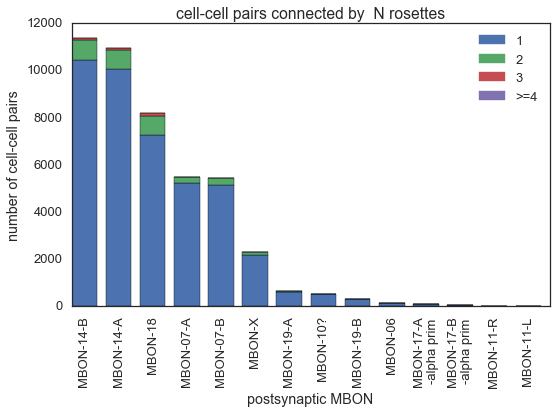

In [8]:
current_palette = sns.color_palette()
fig = pylab.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
width = 0.75
legend_handles = []


ind = np.arange(len(true_pt))


for i in range(1, 5):
    b = {}
    if i > 1:
        b = {'bottom' : np.sum([np.array(true_pt[j]) for j in range(1, i)], axis=0)}
    if i < 4:
        p = true_pt[i]
        label = i
    else:
        p = np.sum([true_pt[j] for j in range(4, 8)], axis=0)
        label = ">=4"
        
    p1 = ax.bar(ind, np.array(p), width, color=current_palette[i-1], **b)
    
    legend_handles.append(matplotlib.patches.Patch(color=current_palette[i-1], label=label))
    

ax.set_ylabel('cell-cell pairs')
ax.set_xlabel('MBON')
ax.set_xticks(ind + width/2.0)
print ax.get_xticks()
names = np.array([neuronsdf.ix[i].name_clean for i in true_pt.index.values])

for i in range(len(names)):
    if '-alpha' in names[i]:
        names[i] = names[i].replace("-alpha", "\n-alpha")

ax.set_xticklabels(names, rotation=90)

ax.legend(handles=legend_handles)

ax.grid(0)
ax.set_title("cell-cell pairs connected by  N rosettes")
fig.tight_layout()
ax.set_xlabel("postsynaptic MBON")
ax.set_ylabel("number of cell-cell pairs")
fig.savefig("MBON rosette pair analysis.cell cell pairs through rosettes.pdf")

# randomization and shuffle check

In [9]:
counts_df = pickle.load(open("../data/mushroombody.all-MBON.rosette.shuffle.counts.pickle", 'r'))
counts_df = counts_df.join(neuronsdf[['name_clean']], on='body ID_post')
a = counts_df[ (~counts_df.convergent_filtered)]


In [10]:
z_score_dict = {}
def z_score(x):
    mu = np.mean(x.conn_pairs)
    sigma = np.std(x.conn_pairs)
    z_score_dict[(x.iloc[0].rosette_num, x.iloc[0].rosette_thold, 
                 x.iloc[0]['body ID_post'])] = (mu, sigma)
    b = x.copy()
    b['z_score'] = (x.conn_pairs - mu)/(sigma) 
    return b
shuffle_df_zscore = a.groupby(['rosette_num', 'rosette_thold', 'body ID_post'],
                              as_index=False).apply(z_score).reset_index()


In [31]:
# now converte true values to zscore
def row_zs(row):
    mu, sigma = z_score_dict[(row.rosette_num, row.rosette_thold, row['body ID_post'])]
    return (row.conn_pairs - mu ) / (sigma +1)#  prevent divide by zero
                 
counts_by_mbon['z_score'] = counts_by_mbon.apply(row_zs, axis=1)


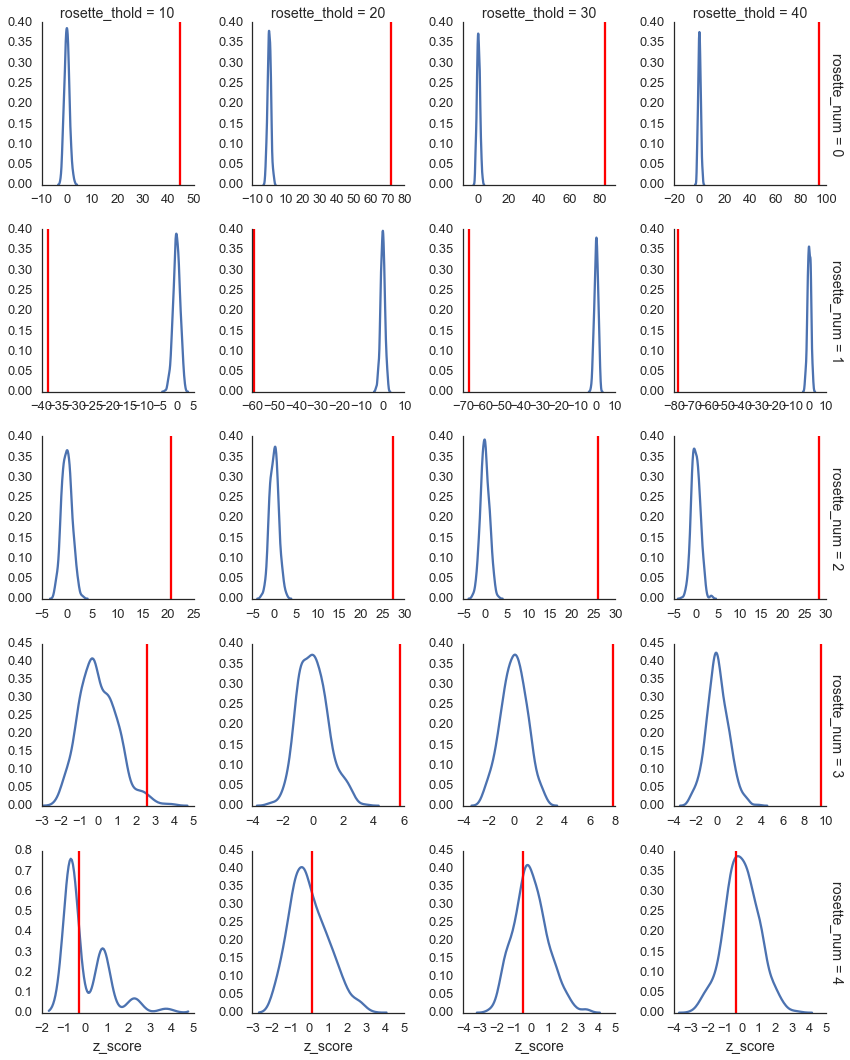

In [33]:

def dateplot(field_name,  **kwargs):
    ax = plt.gca()
    data = kwargs.pop("data")
    a =  data.iloc[0]
    data_row = data.iloc[0]
    assert len(np.unique(data_row['body ID_post'])) == 1
    assert len(np.unique(data_row['rosette_num'])) == 1
    assert len(np.unique(data_row['rosette_thold'])) == 1
    
    rows = counts_by_mbon[(counts_by_mbon['body ID_post'] == data_row['body ID_post'])\
                                & (counts_by_mbon.rosette_num == data_row.rosette_num) 
                                & (counts_by_mbon.rosette_thold == data_row.rosette_thold)]
    row = rows.iloc[0]
    #v = true_vals.iloc[0].conn_pairs
    #mu, sigma = z_score_dict[(data_row.rosette_num, data_row.rosette_thold, data_row['body ID_post'])]
    #v = (v - mu)/sigma
    ax.axvline(row[field_name], c='r')
    #data.plot(x=x, y=y, ax=ax, grid=False, **kwargs)

# single mbon
z_df = shuffle_df_zscore[shuffle_df_zscore.rosette_num < 5]
tgt_mbon = 'MBON-14-A'
z_df = z_df[z_df.name_clean==tgt_mbon]

g = sns.FacetGrid(z_df, 
                  row='rosette_num', col='rosette_thold', 
                  sharex=False, sharey=False,margin_titles=True)
g.map(sns.kdeplot, "z_score")
#g.map(lambda x: print(x))
g.map_dataframe(dateplot, 'z_score')

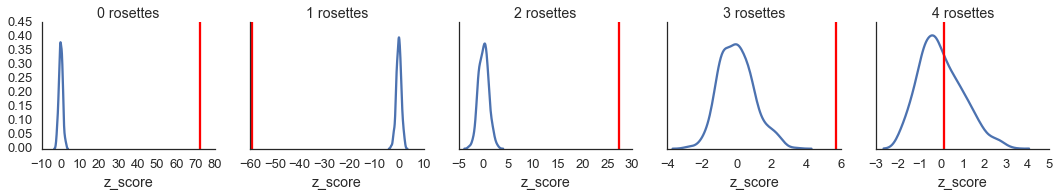

In [49]:
rosette_thold = 20 
z_df_th = z_df[z_df.rosette_thold==rosette_thold]
g = sns.FacetGrid(z_df_th, # [z_df.rosette_thold, 
                  col='rosette_num', #row='rosette_thold',
                  #hue='rosette_thold',
                  sharex=False)
g.map(sns.kdeplot, "z_score")
#g.map(lambda x: print(x))
g.map_dataframe(dateplot, 'z_score')
g.despine()
g.set_titles("{col_name} rosettes")
pylab.savefig("MBON rosette pair analysis.shuffle_hists.{}.{}.zscore.pdf".format(tgt_mbon, rosette_thold))

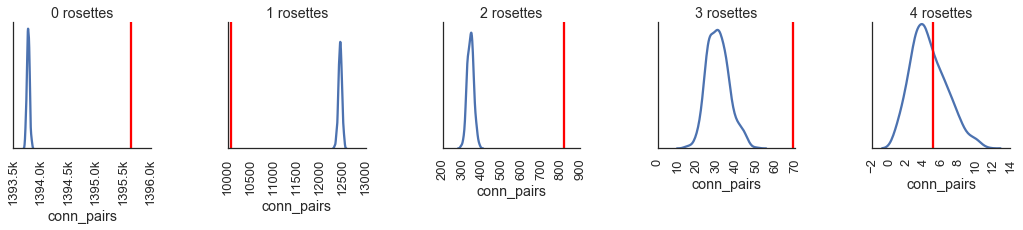

In [50]:
rosette_thold = 20 
z_df_th = z_df[z_df.rosette_thold==rosette_thold]
g = sns.FacetGrid(z_df_th, # [z_df.rosette_thold, 
                  col='rosette_num', #row='rosette_thold',
                  #hue='rosette_thold',
                  sharey = False,
                  sharex=False)
g.map(sns.kdeplot, "conn_pairs")
#g.map(lambda x: print(x))
g.map_dataframe(dateplot, 'conn_pairs')
g.set(yticks=[])
#g.set_xticklabels(rotation=90)
g.despine()
[plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]
g.axes.flat[0].set_xticklabels(["{:3.1f}k".format(x/1e3) for x in  g.axes.flat[0].get_xticks()])
g.set_titles("{col_name} rosettes")
pylab.savefig("MBON rosette pair analysis.shuffle_hists.{}.{}.counts.pdf".format(tgt_mbon, rosette_thold))

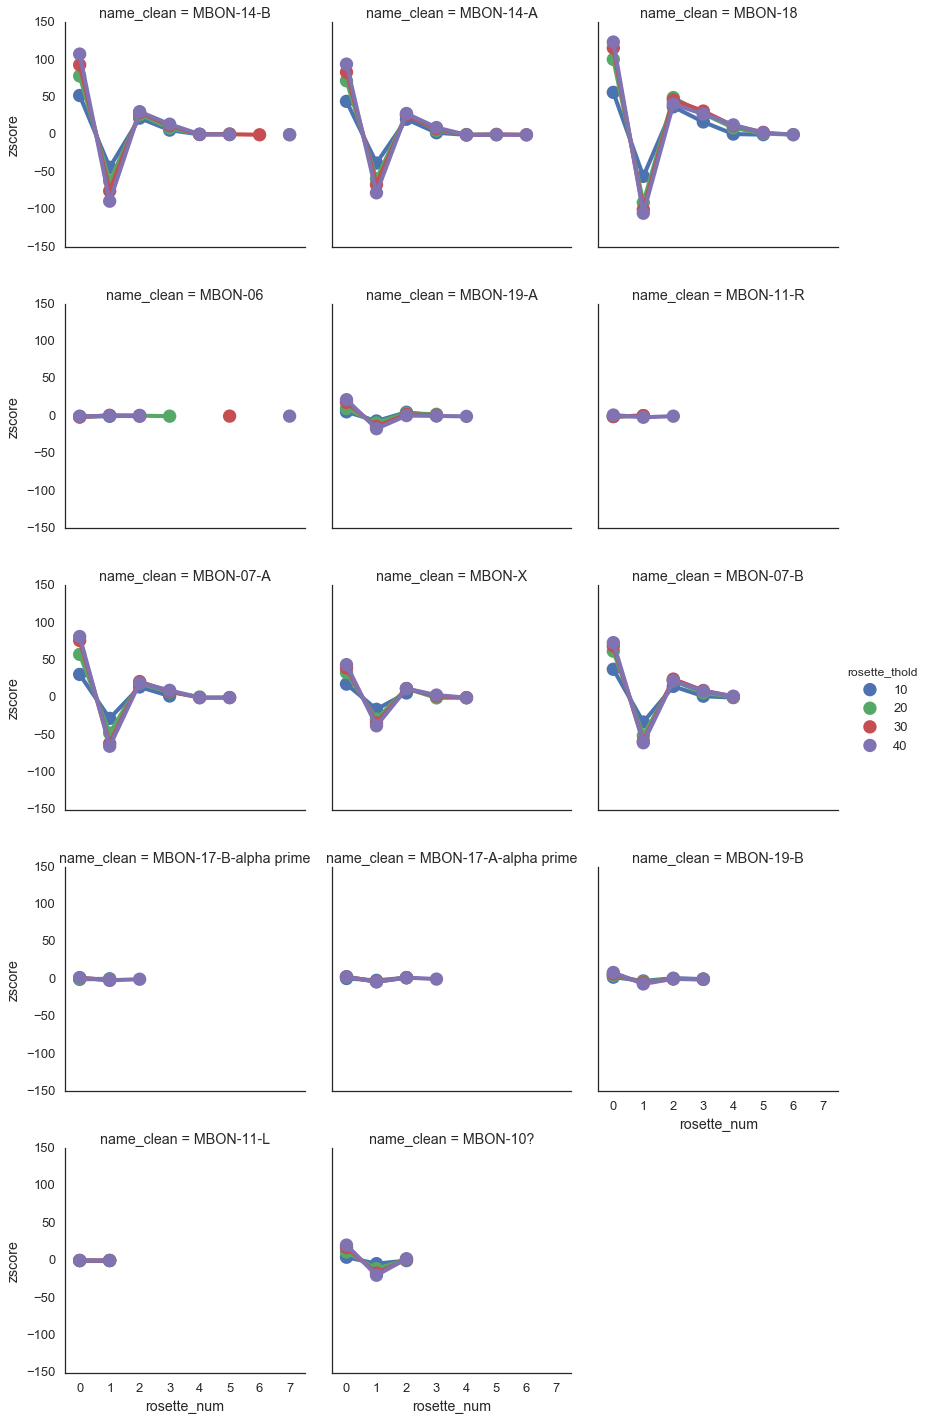

In [14]:
sns.factorplot(x="rosette_num", y="zscore",  col='name_clean', 
              hue='rosette_thold', col_wrap=3, data=counts_by_mbon)

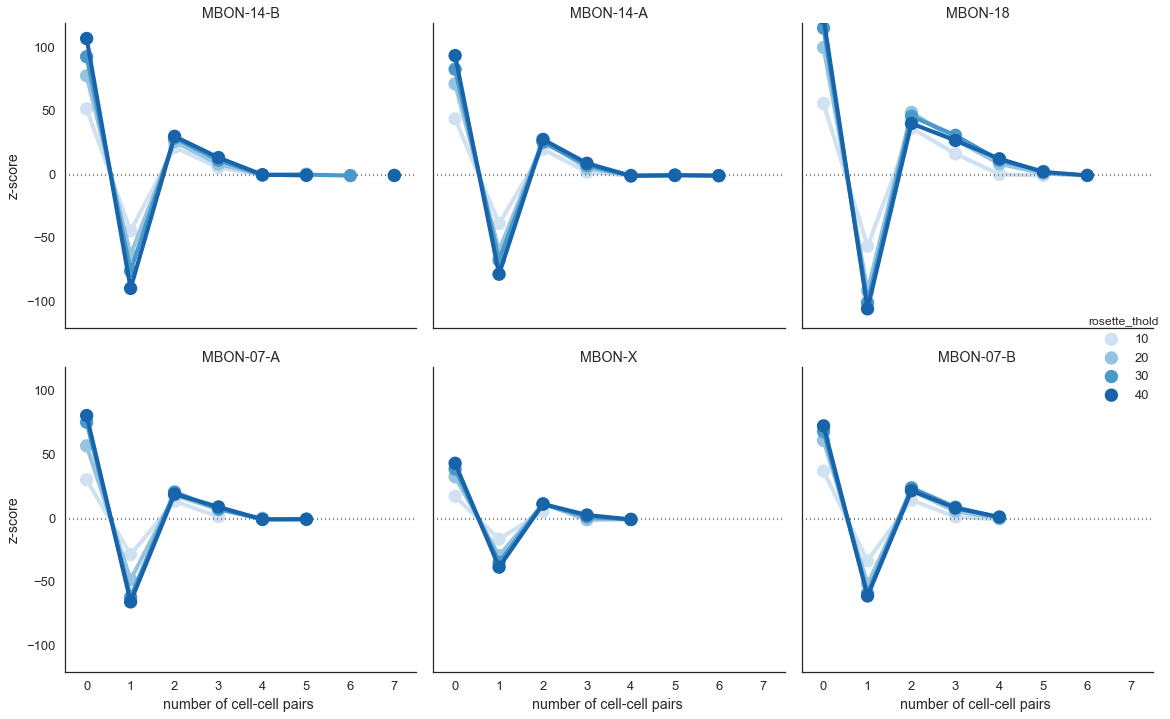

In [15]:
#a = counts_by_mbon[counts_by_mbon.rosette_thold==40]
cells_to_plot = ['MBON-14-A', 'MBON-14-B', 'MBON-18', 'MBON-07-A', "MBON-07-B", "MBON-X"]
sub = counts_by_mbon[counts_by_mbon.name_clean.isin(cells_to_plot)]

g = sns.factorplot(x="rosette_num", y="zscore",  hue='rosette_thold', #col='body ID_post', 
              col='name_clean', col_wrap=3, #ci=10, 
               data=sub, size=5, palette="Blues")
g.map(plt.axhline, y=0, ls=":", c=".5")
g.set(ylim=(-120, 120))
g.set_xlabels('number of cell-cell pairs ')
g.set_ylabels('z-score')
g.set_titles("{col_name}")
pylab.savefig("MBON rosette pair analysis.z-scores.pdf")